# Make maps of temperature and precipitation change in flat10MIP


In [1]:
import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr
#xr.set_options(enable_cftimeindex=True)

import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd

#import xcdat

import matplotlib as mpl
import matplotlib.pyplot as plt

#import cartopy.crs as ccrs
#from cartopy.util import add_cyclic_point

import glob


## notes on packages to add to this kernel
import nc_time_axis
import cartopy.crs as ccrs
import cartopy

import pickle

In [2]:
# load custom functions for analyzing flat10

from loading_function_flat10 import load_flat10, load_grid, select_time_slice, weighted_temporal_mean 

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

### Data location

Data downloaded for nird.sigma2.no to /glade/campaign/cgd/tss/people/aswann/flat10/

#### Models
Models with output:  
ACCESS-ESM1-5  
CESM2  
CNRM-ESM2-1  
GFDL-ESM4  
GISS_E2.1  
NorESM2-LM  
MPI-ESM1-2-LR 

Directory structures within each model folder vary - need to account for this 

#### Experiments
flat10: 200 years at 10Pg/yr  
flat10_zec: branches from flat10 at 100 years, zero emissions for 200 years  
flat10_cdr: branches from flat10 at 100 years, ramps down to negative 10 Pg/yr over 100 years, continues at zero emissions for 100 years (until 200 years past flat10)

Total length of each simulation on its own: 200 years

#### Time indexing
Each model did it's time indexing in a different way. Need to account for all of the different calendars.

#### Missing files
The catalog of all CMIP files on glade is at:  
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.csv.gz'

GISS is missing the land fraction data (sftlf) and cell area data (areacella, areacello)
I tried to find matching grid files on NCAR, but none of the GISS models matched in resolution
Ended up downloading grid files from PCMDI

In [4]:
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

modellist_orig= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris',
            'UKESM1.2']
modellist=modellist_orig

runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

varlist_load=['tas']#,'pr'] #problem with NorESM precipitation files
varlist_analyze=varlist_load
varlist=varlist_load
unitslist=['K','kg m-2 s-1']



modelcolors=['tab:blue','tab:orange','tab:green','tab:red','tab:gray','tab:purple','tab:cyan','gold','tab:brown']
### from ben: colors=["tab:cyan","tab:olive","tab:green","tab:red","tab:gray","tab:pink","limegreen","tab:brown", "slateblue","gold"]

In [5]:
#unitconversions
sperday=60*60*24
speryr=60*60*24*365

PgperKg = 1e-12
# to convert kg m-2 s-1 to kg/m2/yr multiply by speryr

In [6]:
# initialize a dictionary to hold all of the data
data_dict={}

### Load grid info

In [7]:
data_dict = load_grid(data_dict,modellist)

ACCESS-ESM1-5 getting grid info
CESM2 getting grid info
GFDL-ESM4 getting grid info
GISS_E2.1 getting grid info
NorESM2-LM getting grid info
MPI-ESM1-2-LR getting grid info
CNRM-ESM2-1 getting grid info
HadCM3LC-Bris getting grid info
UKESM1.2 getting grid info


### Load data from dictionary

In [8]:
data_dict=load_flat10(data_dict, modellist, runlist, runlist_wc, varlist)

loading model: ACCESS-ESM1-5
loading run: *lat10
loading variable: tas
adding ACCESS-ESM1-5 flat10 to dict
loading run: *zec
loading variable: tas
adding ACCESS-ESM1-5 flat10_zec to dict
loading run: *cdr
loading variable: tas
adding ACCESS-ESM1-5 flat10_cdr to dict
loading model: CESM2
loading run: *lat10
loading variable: tas
adding CESM2 flat10 to dict
loading run: *zec
loading variable: tas
adding CESM2 flat10_zec to dict
loading run: *cdr
loading variable: tas
adding CESM2 flat10_cdr to dict
loading model: GFDL-ESM4
loading run: *lat10
loading variable: tas
adding GFDL-ESM4 flat10 to dict
loading run: *zec
loading variable: tas
adding GFDL-ESM4 flat10_zec to dict
loading run: *cdr
loading variable: tas
adding GFDL-ESM4 flat10_cdr to dict
loading model: GISS_E2.1
loading run: *lat10
loading variable: tas
adding GISS_E2.1 flat10 to dict
loading run: *zec
loading variable: tas
adding GISS_E2.1 flat10_zec to dict
loading run: *cdr
loading variable: tas
adding GISS_E2.1 flat10_cdr to d

In [9]:
modellist=modellist_orig
varlist=varlist_analyze

### Process data into 3 static maps of change

In [11]:

#-- create maps of a few phases and add them to the dictionary

varlist=['tas']#,'pr']

#----loop over models----#
for m in range(len(modellist)):
#for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
    model=modellist[m]
    print('adding model: ' +model)

    # create datasets for each model + experiment combination + variable
    # these are already subset to the correct time blocks
    
    ds0 = data_dict[modellist[m] +'_' +runlist[0]] #flat10
    ds1 = data_dict[modellist[m] +'_' +runlist[1]] #flat10-zec
    ds2 = data_dict[modellist[m] +'_' +runlist[2]] #flat10-cdr
    
    lat = ds0['lat'].values
    lon = ds0['lon'].values   

    for v in range(len(varlist)):
        var=varlist[v]
        print('loading variable: ' +var)
        
        dsw=weighted_temporal_mean(ds0,var)
        dst= select_time_slice(dsw, 0, 19) # first 20 years of flat10
        dsften = dst.mean(dim='time') # original units
        
        dst=select_time_slice(dsw, 80, 99) # last 20 years of flat10  
        dslten0 = dst.mean(dim='time') # original units
    
        dsw=weighted_temporal_mean(ds1,var)
        dst = select_time_slice(dsw, 180, 199) #last 20 years of flat10-zec
        dslten1 = dst.mean(dim='time') # original units
        
        dsw=weighted_temporal_mean(ds2,var)
        dst = select_time_slice(dsw, 180, 199) # last 20 years of flat10-cdr
        dslten2 = dst.mean(dim='time') # original units
      
        #------ end of flat10 emissions phase
        #save output to a dictionary
        print('adding ' +model +' emissions phase' +' to dict')
        data_dict[model +'_endflat10_' +var] = dslten0-dsften
    
        #------ end of flat10 zec
        #save output to a dictionary
        print('adding ' +model +' end zec' +' to dict')
        data_dict[model +'_endzec_' +var] = dslten1-dslten0
    
        #------ end of flat10cdr
        #save output to a dictionary
        print('adding ' +model +' end cdr' +' to dict')
        data_dict[model +'_endcdr_' +var] =dslten2-dsften


    

adding model: ACCESS-ESM1-5
loading variable: tas
adding ACCESS-ESM1-5 emissions phase to dict
adding ACCESS-ESM1-5 end zec to dict
adding ACCESS-ESM1-5 end cdr to dict
adding model: CESM2
loading variable: tas
adding CESM2 emissions phase to dict
adding CESM2 end zec to dict
adding CESM2 end cdr to dict
adding model: GFDL-ESM4
loading variable: tas
adding GFDL-ESM4 emissions phase to dict
adding GFDL-ESM4 end zec to dict
adding GFDL-ESM4 end cdr to dict
adding model: GISS_E2.1
loading variable: tas
adding GISS_E2.1 emissions phase to dict
adding GISS_E2.1 end zec to dict
adding GISS_E2.1 end cdr to dict
adding model: NorESM2-LM
loading variable: tas
adding NorESM2-LM emissions phase to dict
adding NorESM2-LM end zec to dict
adding NorESM2-LM end cdr to dict
adding model: MPI-ESM1-2-LR
loading variable: tas
adding MPI-ESM1-2-LR emissions phase to dict
adding MPI-ESM1-2-LR end zec to dict
adding MPI-ESM1-2-LR end cdr to dict
adding model: CNRM-ESM2-1
loading variable: tas
adding CNRM-ES

## Plots

In [25]:
    
def plot_maps_var(modellist,var,data_dict,tag,clim,unitname=None,unitconvert=None,colormap=None):
      
    '''
     this function makes map plots of all models
     for a single variable and a single "tag" which
     specifies a specific pre-calculated map that resides
     data_dict
     
     data_dict - dictionary to hold xarrays
     modellist - list array of model names that match entries in data_dict
     var - variable to load
     tag - name of specific map in data_dict with form data_dict[modellist[m] +'_endcdr_' +var]
     
    examples:
    modellist= ['ACCESS-ESM1-5',  
                'CESM2',    
                'GFDL-ESM4',  
                'GISS_E2.1',  
                'NorESM2-LM',
                'MPI-ESM1-2-LR',
                'CNRM-ESM2-1',
                'HadCM3LC-Bris'
                'UKESM1.2']
    tag= ['endflat10','endzec','endcdr']
    
    '''
            
    if not unitconvert:
        unitconvert=1
    if not unitname:
        unitname='unknown unit'
    if colormap:
        ccmap=colormap
    else:
        ccmap='RdBu_r'
    # clim = 3 for tas
    
    # Create figures and axis objects
    num_rows=3
    num_cols=3
    subplots_per_fig=num_rows*num_cols
    
    
    # Create axes with Cartopy subplots
    fig, axs = plt.subplots(
        num_rows, num_cols,
        figsize=(15, 10),
        subplot_kw={'projection': ccrs.Robinson()}
    )
    axsg=axs
    axs = axs.flatten()
    
    
    # data location
    outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'
    
    #----loop over models----#
    for m in range(len(modellist)):
    #for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
        model=modellist[m]
        print('plotting model: ' +model)
    
        ds_delta = data_dict[modellist[m] +'_' +tag +'_' +var] #flat10cdr
    
        lat = ds_delta['lat'].values
        lon = ds_delta['lon'].values   
    
        # select correct axes and subplot
        
        subplot_idx = m  #% subplots_per_fig
    
        #------ end of flat10 emissions phase
        # get data into an array
        mapdata= unitconvert*(ds_delta).values
          
        # select which figure and subplot
        ax = axs[subplot_idx]
    
        #------------ PLOT 
        #-- map
        #ax = plt.subplot(num_rows,num_cols,m,projection=ccrs.Robinson())
        ax.coastlines()
        
        ##ax.plot(data)
        pcm = ax.pcolormesh(lon,lat,mapdata,transform=ccrs.PlateCarree(), shading='auto', cmap=ccmap,vmax=clim, vmin=-clim)
        ax.set_title(model)
    
    #------
    #------------ Whole figure attributes
    # adjust the subplots to make space for a colorbar and to decrease spacing between subplots
    #subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    #plt.subplots_adjust(bottom=0.1, right=None, top=None, wspace=.02, hspace=0.5)
    
    # Adjust spacing between subplots
    fig.subplots_adjust(wspace=0.1, hspace=0.2, bottom=0.15)
    
    
    # make an axes for the colorbar
    #cax = plt.axes([left, bottom, width, height])
    #cax = plt.axes([0.25, 0.05, 0.5, 0.018],frameon='no')
    
    # Add a single colorbar below all subplots
    cax = fig.add_axes([0.25, 0.08, 0.5, 0.02],frameon='no')  # [left, bottom, width, height]
    
    # add a colorbar: #was plt.
    #cbar=fig.colorbar(pcm, ax=axes, shrink=0.6, location='bottom',extend='both')
    cbar=fig.colorbar(pcm, cax=cax, orientation='horizontal', extend='both', fraction=0.04, pad=0.05)#shrink=0.6, location='bottom',extend='both')
    
    cbar.ax.tick_params(labelsize=14) 
    
    
    # put a label on the colorbar, e.g. with the units of your field
    cbar.set_label('$\Delta$' +var +' (' +unitname +') ' +tag,fontsize=14)
    
    #- save figure
    #fig.tight_layout()
    fig.show()
    # save the plot
    fig.savefig('figures/' +var +'_globalmaps_' +tag +'.png', bbox_inches='tight', dpi=400)
    print('done saving file ' +tag )


plotting model: ACCESS-ESM1-5
plotting model: CESM2
plotting model: GFDL-ESM4
plotting model: GISS_E2.1
plotting model: NorESM2-LM
plotting model: MPI-ESM1-2-LR
plotting model: CNRM-ESM2-1
plotting model: HadCM3LC-Bris
plotting model: UKESM1.2
done saving file endflat10


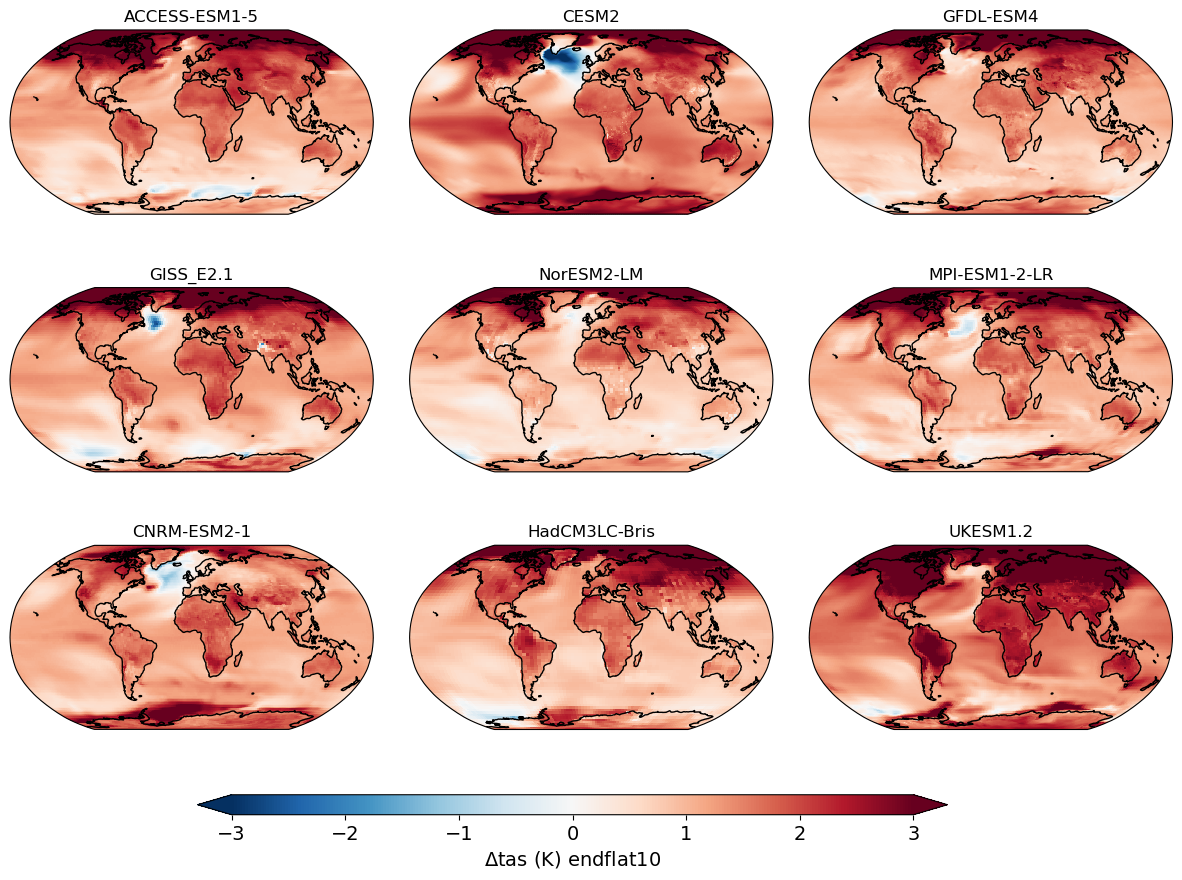

In [27]:
var='tas'
tag='endflat10'
clim=3
unitname='K'
unitconvert=1

plot_maps_var(modellist,var,data_dict,tag,clim,unitname,unitconvert)

plotting model: ACCESS-ESM1-5
plotting model: CESM2
plotting model: GFDL-ESM4
plotting model: GISS_E2.1
plotting model: NorESM2-LM
plotting model: MPI-ESM1-2-LR
plotting model: CNRM-ESM2-1
plotting model: HadCM3LC-Bris
plotting model: UKESM1.2
done saving file endzec


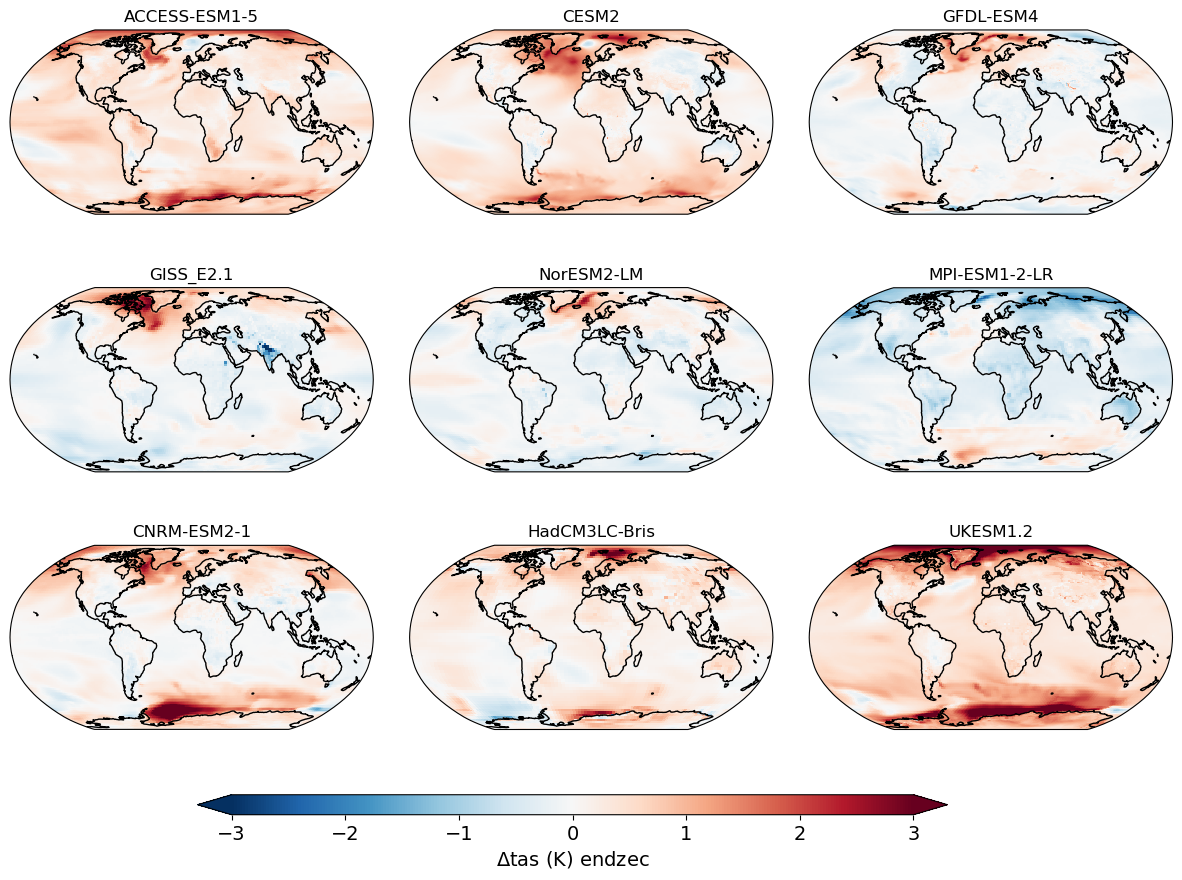

In [28]:
var='tas'
tag='endzec'
clim=3
unitname='K'
unitconvert=1

plot_maps_var(modellist,var,data_dict,tag,clim,unitname,unitconvert)

plotting model: ACCESS-ESM1-5
plotting model: CESM2
plotting model: GFDL-ESM4
plotting model: GISS_E2.1
plotting model: NorESM2-LM
plotting model: MPI-ESM1-2-LR
plotting model: CNRM-ESM2-1
plotting model: HadCM3LC-Bris
plotting model: UKESM1.2
done saving file endcdr


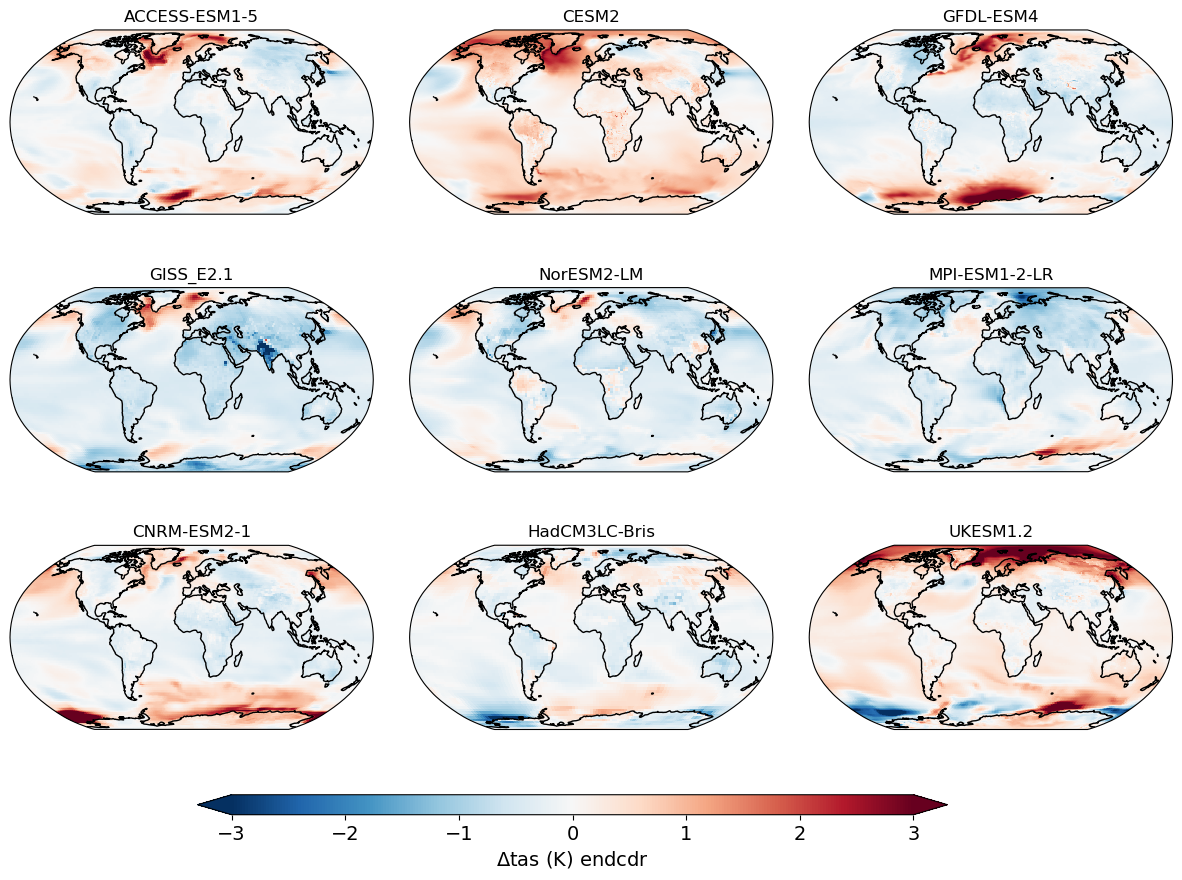

In [29]:
var='tas'
tag='endcdr'
clim=3
unitname='K'
unitconvert=1

plot_maps_var(modellist,var,data_dict,tag,clim,unitname,unitconvert)

# --------- Testing Code below

plotting model: ACCESS-ESM1-5
plotting model: CESM2
plotting model: GFDL-ESM4
plotting model: GISS_E2.1
plotting model: NorESM2-LM
plotting model: MPI-ESM1-2-LR
plotting model: CNRM-ESM2-1
plotting model: HadCM3LC-Bris
plotting model: UKESM1.2
done saving file emissions phase


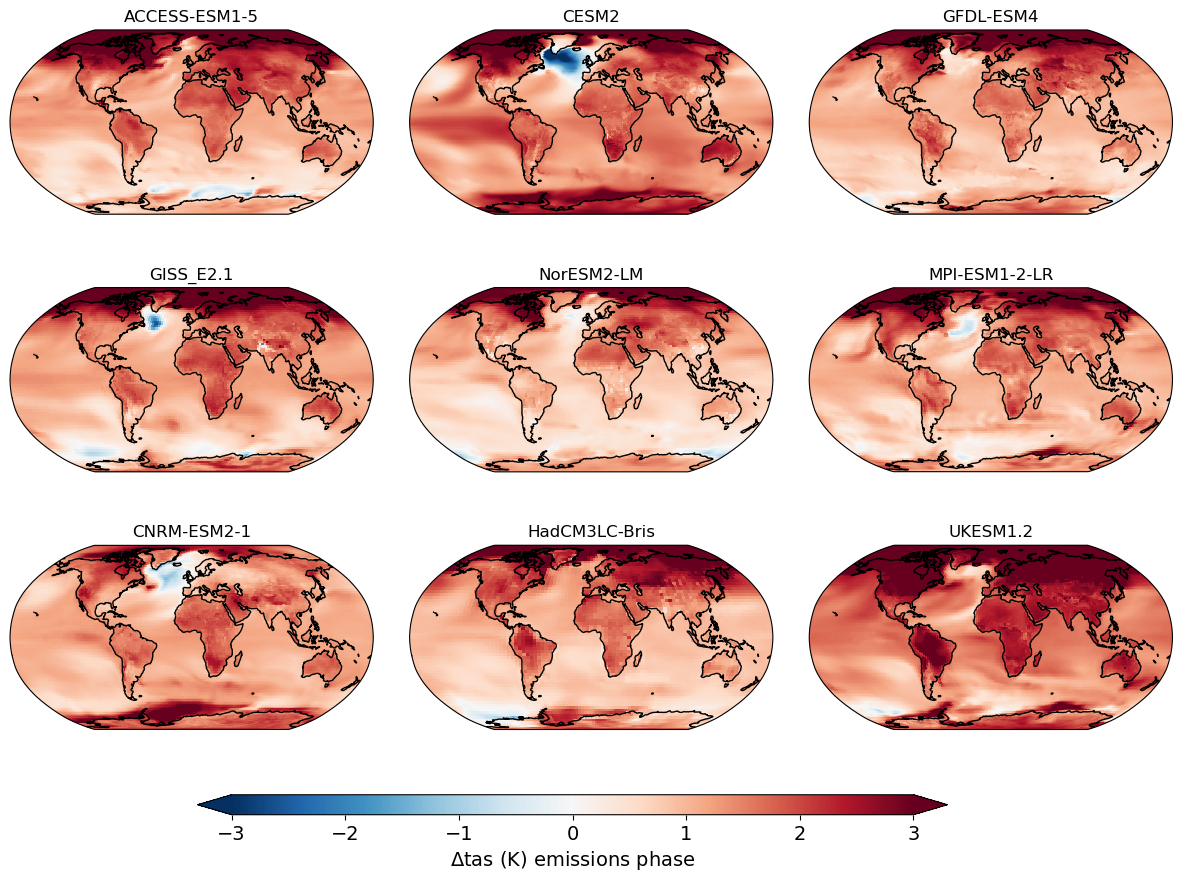

In [14]:

##def plot_maps(modellist,varname,data_dict,clim=None,unitname=None,colormap=None,unitconversion=None):
  
'''
 this function makes map plots of all models
 
 data_dict - dictionary to hold xarrays
 modellist - list array of model names that match filenames
 runlist - list of run names
 runlist_wc - list of run names with wildcards
 varlist - list of variables to load
 
examples:
modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris'
            'UKESM1.2']
runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

varlist_load=['cVeg','cSoil','cLitter','nbp','gpp','rh'] #, 'gpp','fgco2', 'ra', 'rh']#, 'npp'] # not working beyond nbp for norESM
'''
        
var='tas'
unitconvert=1
unitname='K'
clim=3

# Create figures and axis objects
num_rows=3
num_cols=3
subplots_per_fig=num_rows*num_cols


# Create axes with Cartopy subplots
fig, axs = plt.subplots(
    num_rows, num_cols,
    figsize=(15, 10),
    subplot_kw={'projection': ccrs.Robinson()}
)
axsg=axs
axs = axs.flatten()


# data location
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

#----loop over models----#
for m in range(len(modellist)):
#for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
    model=modellist[m]
    print('plotting model: ' +model)

    ds_delta = data_dict[modellist[m] +'_endflat10_' +var] #flat10

    lat = ds_delta['lat'].values
    lon = ds_delta['lon'].values   

    # select correct axes and subplot
    
    subplot_idx = m  #% subplots_per_fig

    #------ end of flat10 emissions phase
    # get data into an array
    mapdata= unitconvert*(ds_delta).values
      
    # select which figure and subplot
    ax = axs[subplot_idx]

    #------------ PLOT 
    #-- map
    #ax = plt.subplot(num_rows,num_cols,m,projection=ccrs.Robinson())
    ax.coastlines()
    
    ##ax.plot(data)
    pcm = ax.pcolormesh(lon,lat,mapdata,transform=ccrs.PlateCarree(), shading='auto', cmap='RdBu_r',vmax=clim, vmin=-clim)
    ax.set_title(model)

#------
#------------ Whole figure attributes
# adjust the subplots to make space for a colorbar and to decrease spacing between subplots
#subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
#plt.subplots_adjust(bottom=0.1, right=None, top=None, wspace=.02, hspace=0.5)

# Adjust spacing between subplots
fig.subplots_adjust(wspace=0.1, hspace=0.2, bottom=0.15)


# make an axes for the colorbar
#cax = plt.axes([left, bottom, width, height])
#cax = plt.axes([0.25, 0.05, 0.5, 0.018],frameon='no')

# Add a single colorbar below all subplots
cax = fig.add_axes([0.25, 0.08, 0.5, 0.02],frameon='no')  # [left, bottom, width, height]

# add a colorbar: #was plt.
#cbar=fig.colorbar(pcm, ax=axes, shrink=0.6, location='bottom',extend='both')
cbar=fig.colorbar(pcm, cax=cax, orientation='horizontal', extend='both', fraction=0.04, pad=0.05)#shrink=0.6, location='bottom',extend='both')

cbar.ax.tick_params(labelsize=14) 


# put a label on the colorbar, e.g. with the units of your field
cbar.set_label('$\Delta$' +var +' (' +unitname +') emissions phase',fontsize=14)

#- save figure
#fig.tight_layout()
fig.show()
# save the plot
fig.savefig('figures/' +var +'_globalmaps_emissionsphase.png', bbox_inches='tight', dpi=400)
print('done saving file emissions phase' )


plotting model: ACCESS-ESM1-5
plotting model: CESM2
plotting model: GFDL-ESM4
plotting model: GISS_E2.1
plotting model: NorESM2-LM
plotting model: MPI-ESM1-2-LR
plotting model: CNRM-ESM2-1
plotting model: HadCM3LC-Bris
plotting model: UKESM1.2
done saving file end of zec phase


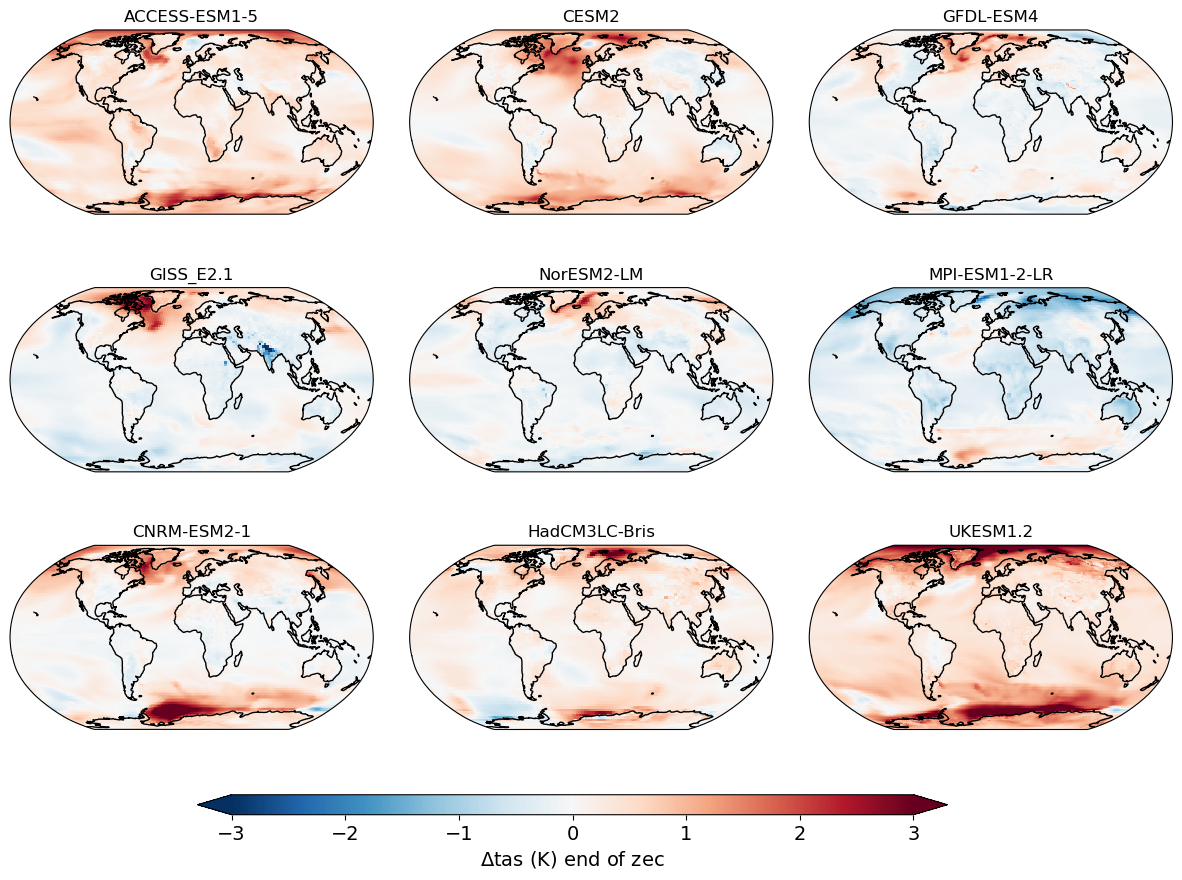

In [15]:

##def plot_maps(modellist,varname,data_dict,clim=None,unitname=None,colormap=None,unitconversion=None):
  
'''
 this function makes map plots of all models
 
 data_dict - dictionary to hold xarrays
 modellist - list array of model names that match filenames
 runlist - list of run names
 runlist_wc - list of run names with wildcards
 varlist - list of variables to load
 
examples:
modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris'
            'UKESM1.2']
runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

varlist_load=['cVeg','cSoil','cLitter','nbp','gpp','rh'] #, 'gpp','fgco2', 'ra', 'rh']#, 'npp'] # not working beyond nbp for norESM
'''
        
var='tas'
unitconvert=1
unitname='K'
clim=3

# Create figures and axis objects
num_rows=3
num_cols=3
subplots_per_fig=num_rows*num_cols


# Create axes with Cartopy subplots
fig, axs = plt.subplots(
    num_rows, num_cols,
    figsize=(15, 10),
    subplot_kw={'projection': ccrs.Robinson()}
)
axsg=axs
axs = axs.flatten()


# data location
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

#----loop over models----#
for m in range(len(modellist)):
#for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
    model=modellist[m]
    print('plotting model: ' +model)

    ds_delta = data_dict[modellist[m] +'_endzec_' +var] #flat10zec

    lat = ds_delta['lat'].values
    lon = ds_delta['lon'].values   

    # select correct axes and subplot
    
    subplot_idx = m  #% subplots_per_fig

    #------ end of flat10 emissions phase
    # get data into an array
    mapdata= unitconvert*(ds_delta).values
      
    # select which figure and subplot
    ax = axs[subplot_idx]

    #------------ PLOT 
    #-- map
    #ax = plt.subplot(num_rows,num_cols,m,projection=ccrs.Robinson())
    ax.coastlines()
    
    ##ax.plot(data)
    pcm = ax.pcolormesh(lon,lat,mapdata,transform=ccrs.PlateCarree(), shading='auto', cmap='RdBu_r',vmax=clim, vmin=-clim)
    ax.set_title(model)

#------
#------------ Whole figure attributes
# adjust the subplots to make space for a colorbar and to decrease spacing between subplots
#subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
#plt.subplots_adjust(bottom=0.1, right=None, top=None, wspace=.02, hspace=0.5)

# Adjust spacing between subplots
fig.subplots_adjust(wspace=0.1, hspace=0.2, bottom=0.15)


# make an axes for the colorbar
#cax = plt.axes([left, bottom, width, height])
#cax = plt.axes([0.25, 0.05, 0.5, 0.018],frameon='no')

# Add a single colorbar below all subplots
cax = fig.add_axes([0.25, 0.08, 0.5, 0.02],frameon='no')  # [left, bottom, width, height]

# add a colorbar: #was plt.
#cbar=fig.colorbar(pcm, ax=axes, shrink=0.6, location='bottom',extend='both')
cbar=fig.colorbar(pcm, cax=cax, orientation='horizontal', extend='both', fraction=0.04, pad=0.05)#shrink=0.6, location='bottom',extend='both')

cbar.ax.tick_params(labelsize=14) 


# put a label on the colorbar, e.g. with the units of your field
cbar.set_label('$\Delta$' +var +' (' +unitname +') end of zec',fontsize=14)

#- save figure
#fig.tight_layout()
fig.show()
# save the plot
fig.savefig('figures/' +var +'_globalmaps_endzec.png', bbox_inches='tight', dpi=400)
print('done saving file end of zec phase' )


plotting model: ACCESS-ESM1-5
plotting model: CESM2
plotting model: GFDL-ESM4
plotting model: GISS_E2.1
plotting model: NorESM2-LM
plotting model: MPI-ESM1-2-LR
plotting model: CNRM-ESM2-1
plotting model: HadCM3LC-Bris
plotting model: UKESM1.2
done saving file end of cdr phase


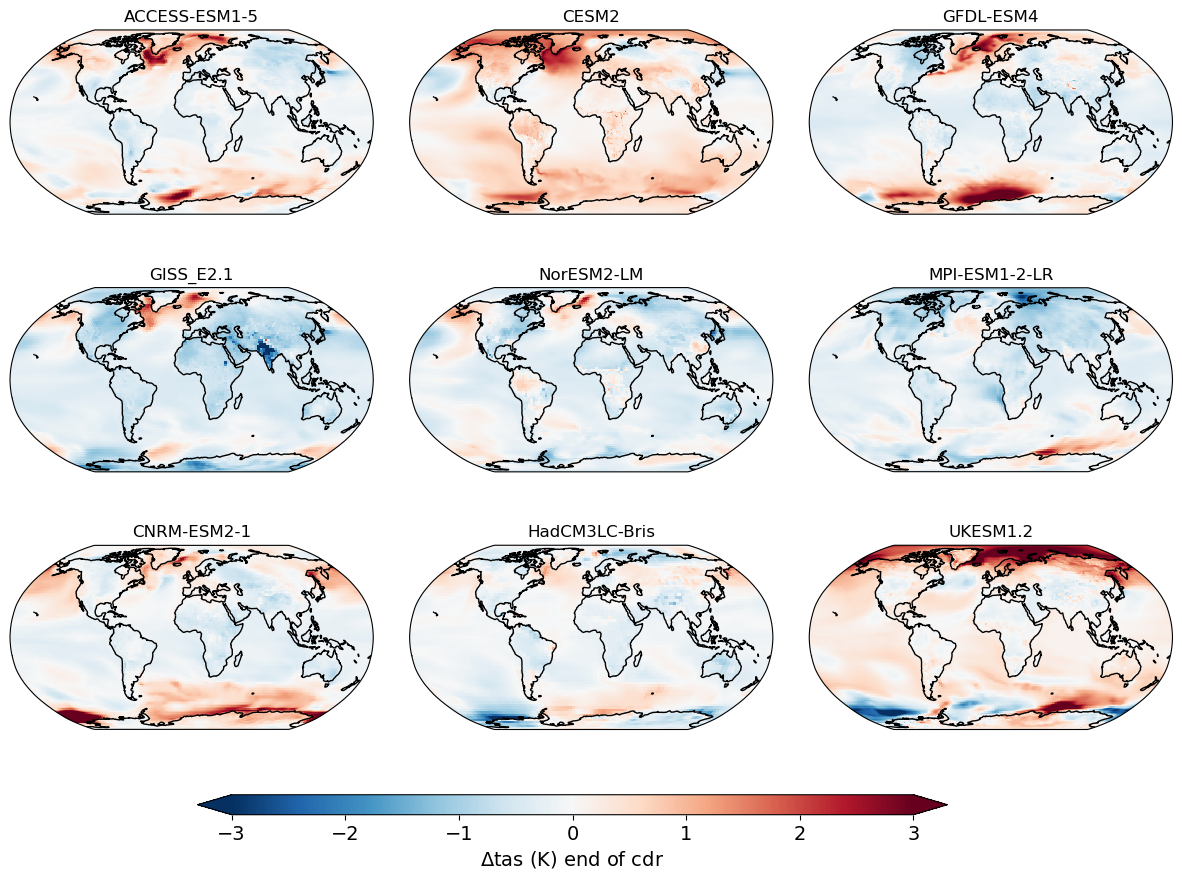

In [16]:

##def plot_maps(modellist,varname,data_dict,clim=None,unitname=None,colormap=None,unitconversion=None):
  
'''
 this function makes map plots of all models
 
 data_dict - dictionary to hold xarrays
 modellist - list array of model names that match filenames
 runlist - list of run names
 runlist_wc - list of run names with wildcards
 varlist - list of variables to load
 
examples:
modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris'
            'UKESM1.2']
runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

varlist_load=['cVeg','cSoil','cLitter','nbp','gpp','rh'] #, 'gpp','fgco2', 'ra', 'rh']#, 'npp'] # not working beyond nbp for norESM
'''
        
var='tas'
unitconvert=1
unitname='K'
clim=3

# Create figures and axis objects
num_rows=3
num_cols=3
subplots_per_fig=num_rows*num_cols


# Create axes with Cartopy subplots
fig, axs = plt.subplots(
    num_rows, num_cols,
    figsize=(15, 10),
    subplot_kw={'projection': ccrs.Robinson()}
)
axsg=axs
axs = axs.flatten()


# data location
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

#----loop over models----#
for m in range(len(modellist)):
#for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
    model=modellist[m]
    print('plotting model: ' +model)

    ds_delta = data_dict[modellist[m] +'_endcdr_' +var] #flat10cdr

    lat = ds_delta['lat'].values
    lon = ds_delta['lon'].values   

    # select correct axes and subplot
    
    subplot_idx = m  #% subplots_per_fig

    #------ end of flat10 emissions phase
    # get data into an array
    mapdata= unitconvert*(ds_delta).values
      
    # select which figure and subplot
    ax = axs[subplot_idx]

    #------------ PLOT 
    #-- map
    #ax = plt.subplot(num_rows,num_cols,m,projection=ccrs.Robinson())
    ax.coastlines()
    
    ##ax.plot(data)
    pcm = ax.pcolormesh(lon,lat,mapdata,transform=ccrs.PlateCarree(), shading='auto', cmap='RdBu_r',vmax=clim, vmin=-clim)
    ax.set_title(model)

#------
#------------ Whole figure attributes
# adjust the subplots to make space for a colorbar and to decrease spacing between subplots
#subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
#plt.subplots_adjust(bottom=0.1, right=None, top=None, wspace=.02, hspace=0.5)

# Adjust spacing between subplots
fig.subplots_adjust(wspace=0.1, hspace=0.2, bottom=0.15)


# make an axes for the colorbar
#cax = plt.axes([left, bottom, width, height])
#cax = plt.axes([0.25, 0.05, 0.5, 0.018],frameon='no')

# Add a single colorbar below all subplots
cax = fig.add_axes([0.25, 0.08, 0.5, 0.02],frameon='no')  # [left, bottom, width, height]

# add a colorbar: #was plt.
#cbar=fig.colorbar(pcm, ax=axes, shrink=0.6, location='bottom',extend='both')
cbar=fig.colorbar(pcm, cax=cax, orientation='horizontal', extend='both', fraction=0.04, pad=0.05)#shrink=0.6, location='bottom',extend='both')

cbar.ax.tick_params(labelsize=14) 


# put a label on the colorbar, e.g. with the units of your field
cbar.set_label('$\Delta$' +var +' (' +unitname +') end of cdr',fontsize=14)

#- save figure
#fig.tight_layout()
fig.show()
# save the plot
fig.savefig('figures/' +var +'_globalmaps_endcdr.png', bbox_inches='tight', dpi=400)
print('done saving file end of cdr phase' )


In [ ]:

##def plot_maps(modellist,varname,data_dict,clim=None,unitname=None,colormap=None,unitconversion=None):
  
'''
 this function makes map plots of all models
 
 data_dict - dictionary to hold xarrays
 modellist - list array of model names that match filenames
 runlist - list of run names
 runlist_wc - list of run names with wildcards
 varlist - list of variables to load
 
examples:
modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris'
            'UKESM1.2']
runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

varlist_load=['cVeg','cSoil','cLitter','nbp','gpp','rh'] #, 'gpp','fgco2', 'ra', 'rh']#, 'npp'] # not working beyond nbp for norESM
'''
        
var='tas'
unitconvert=1
unitname='K'
clim=3

# Create figures and axis objects
num_rows=3
num_cols=3
subplots_per_fig=num_rows*num_cols


# Create axes with Cartopy subplots
fig, axs = plt.subplots(
    num_rows, num_cols,
    figsize=(15, 10),
    subplot_kw={'projection': ccrs.Robinson()}
)
axsg=axs
axs = axs.flatten()


# data location
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

#----loop over models----#
for m in range(len(modellist)):
#for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
    model=modellist[m]
    print('plotting model: ' +model)

    ds_delta = data_dict[modellist[m] +'_endflat10'] #flat10

    lat = ds_delta['lat'].values
    lon = ds_delta['lon'].values   

    # select correct axes and subplot
    
    subplot_idx = m  #% subplots_per_fig

    #------ end of flat10 emissions phase
    # get data into an array
    mapdata= unitconvert*(ds_delta).values
      
    # select which figure and subplot
    ax = axs[subplot_idx]

    #------------ PLOT 
    #-- map
    #ax = plt.subplot(num_rows,num_cols,m,projection=ccrs.Robinson())
    ax.coastlines()
    
    ##ax.plot(data)
    pcm = ax.pcolormesh(lon,lat,mapdata,transform=ccrs.PlateCarree(), shading='auto', cmap='RdBu_r',vmax=clim, vmin=-clim)
    ax.set_title(model)

#------
#------------ Whole figure attributes
# adjust the subplots to make space for a colorbar and to decrease spacing between subplots
#subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
# Adjust spacing between subplots
fig.subplots_adjust(wspace=0.1, hspace=0.2, bottom=0.15)

# Add a single colorbar below all subplots
cax = fig.add_axes([0.25, 0.08, 0.5, 0.02],frameon='no')  # [left, bottom, width, height]

# add a colorbar: 
cbar=fig.colorbar(pcm, ax=axs, orientation='horizontal', extend='both', fraction=0.04, pad=0.05)#shrink=0.6, location='bottom',extend='both')

#cbar.ax.tick_params(labelsize=14) 

# put a label on the colorbar, e.g. with the units of your field
cbar.set_label('$\Delta$' +var +' (' +unitname +') emissions phase',fontsize=14)

#- save figure
fig.show()
# save the plot
fig.savefig('figures/' +var +'_globalmaps_emissionsphase.png', bbox_inches='tight', dpi=400)
print('done saving file emissions phase' )


In [ ]:
##def plot_maps(modellist,varname,data_dict,clim=None,unitname=None,colormap=None,unitconversion=None):
  
'''
 this function makes map plots of all models
 
 data_dict - dictionary to hold xarrays
 modellist - list array of model names that match filenames
 runlist - list of run names
 runlist_wc - list of run names with wildcards
 varlist - list of variables to load
 
examples:
modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris'
            'UKESM1.2']
runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

varlist_load=['cVeg','cSoil','cLitter','nbp','gpp','rh'] #, 'gpp','fgco2', 'ra', 'rh']#, 'npp'] # not working beyond nbp for norESM
'''
        
var='tas'
unitconvert=1
unitname='K'

# Create figures and axis objects
num_rows=3
num_cols=3
num_figs=3
subplots_per_fig=num_rows*num_cols
#fig0, axs0 = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 6))
#fig1, axs1 = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 6))
#fig2, axs2 = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 6))
#fig3, axs3 = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 6))


# Store figures and axes
figures = []
axes = []


# Create figures with Cartopy subplots
for _ in range(num_figs):
    fig, axs = plt.subplots(
        num_rows, num_cols,
        figsize=(15, 10),
        subplot_kw={'projection': ccrs.Robinson()}
    )
    axs = axs.flatten()
    figures.append(fig)
    axes.append(axs)

# data location
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

#----loop over models----#
for m in range(len(modellist)):
#for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
    model=modellist[m]
    print('plotting model: ' +model)


    # create datasets for each model + experiment combination + variable
    # these are already subset to the correct time blocks
    
    ds0 = data_dict[modellist[m] +'_' +runlist[0]] #flat10
    ds1 = data_dict[modellist[m] +'_' +runlist[1]] #flat10-zec
    ds2 = data_dict[modellist[m] +'_' +runlist[2]] #flat10-cdr
    
    lat = ds0['lat'].values
    lon = ds0['lon'].values   

    dsw=weighted_temporal_mean(ds0,var)
    dst= select_time_slice(dsw, 0, 19) # first 20 years of flat10
    dsften = dst.mean(dim='time') # original units
    
    dst=select_time_slice(dsw, 80, 99) # last 20 years of flat10  
    dslten0 = dst.mean(dim='time') # original units

    dsw=weighted_temporal_mean(ds1,var)
    dst = select_time_slice(dsw, 180, 199) #last 20 years of flat10-zec
    dslten1 = dst.mean(dim='time') # original units
    
    dsw=weighted_temporal_mean(ds2,var)
    dst = select_time_slice(dsw, 180, 199) # last 20 years of flat10-cdr
    dslten2 = dst.mean(dim='time') # original units

    # select correct axes and subplot
    
    subplot_idx = m  #% subplots_per_fig

    #------ end of flat10 emissions phase
    fig_idx = 0 
    # get data into an array
    mapdata= unitconvert*(dslten0-dsften).values
      
    # select which figure and subplot
    ax = axes[fig_idx][subplot_idx]

    #------------ PLOT 
    #-- map
    #ax = plt.subplot(num_rows,num_cols,m,projection=ccrs.Robinson())
    ax.coastlines()
    
    ##ax.plot(data)
    pcm = ax.pcolormesh(lon,lat,mapdata,transform=ccrs.PlateCarree(), shading='auto', cmap='RdBu_r')



    #------ end of flat10 zec
    fig_idx = 1 
    # get data into an array
    mapdata= unitconvert*(dslten1-dslten0).values
      
    # select which figure and subplot
    ax = axes[fig_idx][subplot_idx]

    #------------ PLOT 
    #-- map
    #ax = plt.subplot(num_rows,num_cols,m,projection=ccrs.Robinson())
    ax.coastlines()
    
    ##ax.plot(data)
    pcm = ax.pcolormesh(lon,lat,mapdata,transform=ccrs.PlateCarree(), shading='auto', cmap='RdBu_r')


    #------ end of flat10cdr
    fig_idx = 2 
    # get data into an array
    mapdata= unitconvert*(dslten2-dsften).values
      
    # select which figure and subplot
    ax = axes[fig_idx][subplot_idx]

    #------------ PLOT 
    #-- map
    #ax = plt.subplot(num_rows,num_cols,m,projection=ccrs.Robinson())
    ax.coastlines()
    
    ##ax.plot(data)
    pcm = ax.pcolormesh(lon,lat,mapdata,transform=ccrs.PlateCarree(), shading='auto', cmap='RdBu_r')



#------
# add colorbars
for fig, axs in zip(figures, axes):
    cbar = fig.colorbar(pcm, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05)
    cbar.ax.tick_params(labelsize=14) 
    
    # set color limits for the colorbar
    if clim:
        cs.set_clim(clim)
        cbar.set_clim(clim)
    
    # put a label on the colorbar, e.g. with the units of your field
    cbar.set_label('$\Delta$' +var +' (' +unitname +') emissions phase',fontsize=14)

    

fig=figures[0]
fig.tight_layout()
fig.show()
# save the plot
fig.savefig('figures/' +varname +'_globalmaps_emissionsphase.png', bbox_inches='tight', dpi=400)
print('done saving file emissions phase' )

fig=figures[1]
fig.tight_layout()
fig.show()
# save the plot
fig.savefig('figures/' +varname +'_globalmaps_endzec.png', bbox_inches='tight', dpi=400)
print('done saving file zero emissions' )

fig=figures[2]
fig.tight_layout()
fig.show()
# save the plot
fig.savefig('figures/' +varname +'_globalmaps_endcdr.png', bbox_inches='tight', dpi=400)
print('done saving file reversibility' )


In [ ]:
# Show all figures
for fig in figures:
    fig.tight_layout()
    fig.show()
    # save the plot
    fig.savefig('figures/' +varname +'_globalmaps_.png', bbox_inches='tight', dpi=1200)
    print('done saving file')




# select a figure
    gax=axs0[m]
    plt.sca(gax)

    # get data
    ds_delta= unitconvert*dsften.values

    #------------ PLOT 
    lat = ds_delta['lat'].values
    lon = ds_delta['lon'].values   

    #-- map
    ax = plt.subplot(num_rows,num_cols,m,projection=ccrs.Robinson())
    ax.coastlines()

    #-- Make the actual Plot
    cs = plt.pcolormesh(lon,lat,mapdata,transform=ccrs.PlateCarree())#Robinson())#

    # choose your colormap:
    if colormap:
        plt.set_cmap(colormap)
    else: #assume red-blue diverging
        plt.set_cmap(plt.cm.RdBu) #vlag looks nice in seaborne but don't know how to export it

    # set a title:
    #plt.title('Delta ' +varname +', ' +ExperimentName +'_' +runname,fontsize=16,y=1.05)
    plt.title(model,fontsize=12)#,y=1)
    

    # you have to do it seperately for the plot and colorbar-its always self consistent but
    # can be really ugly if you only do one
    if clim: 
        plt.clim(clim) 

            
#------------ Whole figure attributes
# adjust the subplots to make space for a colorbar and to decrease spacing between subplots
#subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.subplots_adjust(bottom=0.08, right=None, top=None, wspace=.02, hspace=0.15)

# make an axes for the colorbar
#cax = plt.axes([left, bottom, width, height])
cax = plt.axes([0.25, 0.05, 0.5, 0.018],frameon='no')

# add a colorbar:
cbar = plt.colorbar(cax=cax,orientation='horizontal',extend='both')#,pad=.02, shrink=0.9) #use cax here, which means getting rid of pad
cbar.ax.tick_params(labelsize=14) 

# set color limits for the colorbar
if clim:
    cs.set_clim(clim)
    cbar.set_clim(clim)

# put a label on the colorbar, e.g. with the units of your field
cbar.set_label('$\Delta$' +varname +' (' +unitname +')',fontsize=14)


# show the plot:
plt.show()

# save the plot
#fig.savefig('figures/' +varname +'_globalmaps_allens.png', bbox_inches='tight', dpi=1200)

#print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

In [ ]:
# Initialize figures and axes
figures = []
axes = []

for i in range(num_figs):
    fig, axs = plt.subplots(1, subplots_per_fig, figsize=(10, 4))
    # Ensure axs is always iterable
    if subplots_per_fig == 1:
        axs = [axs]
    figures.append(fig)
    axes.append(axs)

# Fill subplots with data using a single loop
for i, data in enumerate(datasets):
    fig_idx = i // subplots_per_fig  # which figure
    subplot_idx = i % subplots_per_fig  # which subplot in that figure
    ax = axes[fig_idx][subplot_idx]
    ax.plot(data)
    ax.set_title(f"Dataset {i+1}")

# Show all figures
for fig in figures:
    fig.tight_layout()
    fig.show()  # Or use plt.show() if not in a notebook


############

import matplotlib.pyplot as plt

# Let's say you have a list of datasets (here using dummy data)
datasets = [range(i, i + 10) for i in range(0, 90, 10)]  # 9 datasets per figure × 3 figures = 27 datasets

# Constants
subplots_per_fig = 9
num_rows, num_cols = 3, 3

# Calculate how many figures you need
num_figs = (len(datasets) + subplots_per_fig - 1) // subplots_per_fig  # ceiling division

# Store figures and axes
figures = []
axes = []

for i in range(num_figs):
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 10))
    axs = axs.flatten()  # make it easier to index
    figures.append(fig)
    axes.append(axs)

# Fill subplots with data
for i, data in enumerate(datasets):
    fig_idx = i // subplots_per_fig
    subplot_idx = i % subplots_per_fig
    ax = axes[fig_idx][subplot_idx]
    ax.plot(data)
    ax.set_title(f"Dataset {i+1}")

# Optional: Hide unused subplots if datasets don't fill the last figure
for j in range(len(datasets), num_figs * subplots_per_fig):
    fig_idx = j // subplots_per_fig
    subplot_idx = j % subplots_per_fig
    axes[fig_idx][subplot_idx].axis('off')

# Show all figures
for fig in figures:
    fig.tight_layout()
    fig.show()  # Use plt.show() in scripts


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Generate dummy lat/lon grid and data
lon = np.linspace(-180, 180, 100)
lat = np.linspace(-90, 90, 50)
LON, LAT = np.meshgrid(lon, lat)

datasets = []
for i in range(27):  # 3 figures × 9 subplots
    Z = np.sin(np.radians(LON)) * np.cos(np.radians(LAT)) + i * 0.1
    datasets.append((LON, LAT, Z))

# Plot config
num_rows, num_cols = 3, 3
subplots_per_fig = num_rows * num_cols
num_figs = (len(datasets) + subplots_per_fig - 1) // subplots_per_fig

figures = []
axes = []

# Create figures with Cartopy subplots
for _ in range(num_figs):
    fig, axs = plt.subplots(
        num_rows, num_cols,
        figsize=(15, 10),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    axs = axs.flatten()
    figures.append(fig)
    axes.append(axs)

# Plot data
for i, (LON, LAT, Z) in enumerate(datasets):
    fig_idx = i // subplots_per_fig
    subplot_idx = i % subplots_per_fig
    ax = axes[fig_idx][subplot_idx]

    pcm = ax.pcolormesh(LON, LAT, Z, transform=ccrs.PlateCarree(), shading='auto', cmap='viridis')
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_title(f"Dataset {i+1}")

# Hide unused axes
for j in range(len(datasets), num_figs * subplots_per_fig):
    fig_idx = j // subplots_per_fig
    subplot_idx = j % subplots_per_fig
    axes[fig_idx][subplot_idx].axis('off')

# Optional: add colorbars
for fig, axs in zip(figures, axes):
    cbar = fig.colorbar(pcm, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05)

# Show all figures
for fig in figures:
    fig.tight_layout()
    fig.show()


In [ ]:
#----loop over models----#
for m in range(len(list)):
#for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
    model=modellist[m]
    print('plotting model: ' +model)

    ds_delta = data_dict[modellist[m] +'_var'] 
    lat = ds_delta['lat'].values
    lon = ds_delta['lon'].values   

    # select correct axes and subplot
    subplot_idx = m  #% subplots_per_fig

    #------ end of flat10 emissions phase
    # get data into an array
    mapdata= unitconvert*(ds_delta).values
      
    # select which figure and subplot
    ax = axs[subplot_idx]

    #------------ PLOT 
    #-- map
    #ax = plt.subplot(num_rows,num_cols,m,projection=ccrs.Robinson())
    ax.coastlines()
    
    ##ax.plot(data)
    pcm = ax.pcolormesh(lon,lat,mapdata,transform=ccrs.PlateCarree(), shading='auto', cmap='RdBu_r',vmax=clim, vmin=-clim)
    ax.set_title(model)

#------
#------------ Whole figure attributes
# adjust the subplots to make space for a colorbar and to decrease spacing between subplots
#subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
# Adjust spacing between subplots
fig.subplots_adjust(wspace=0.1, hspace=0.2, bottom=0.15)

# Add a single colorbar below all subplots
cax = fig.add_axes([0.25, 0.08, 0.5, 0.02],frameon='no')  # [left, bottom, width, height]

# add a colorbar: 
cbar=fig.colorbar(pcm, ax=axs, orientation='horizontal', extend='both', fraction=0.04, pad=0.05)#shrink=0.6, location='bottom',extend='both')

#cbar.ax.tick_params(labelsize=14) 

# put a label on the colorbar, e.g. with the units of your field
cbar.set_label('$\Delta$' +var +' (' +unitname +') emissions phase',fontsize=14)

#- show figure
fig.show()

In [ ]:
#-- create maps of a few phases and add them to the dictionary
##def plot_maps(modellist,varname,data_dict,clim=None,unitname=None,colormap=None,unitconversion=None):
  
'''
 this function makes map plots of all models
 
 data_dict - dictionary to hold xarrays
 modellist - list array of model names that match filenames
 runlist - list of run names
 runlist_wc - list of run names with wildcards
 varlist - list of variables to load
 
examples:
modellist= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris'
            'UKESM1.2']
runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

varlist_load=['cVeg','cSoil','cLitter','nbp','gpp','rh'] #, 'gpp','fgco2', 'ra', 'rh']#, 'npp'] # not working beyond nbp for norESM
'''
        
var='tas'
unitconvert=1
unitname='K'


# data location
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

#----loop over models----#
for m in range(len(modellist)):
#for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
    model=modellist[m]
    print('adding model: ' +model)

    # create datasets for each model + experiment combination + variable
    # these are already subset to the correct time blocks
    
    ds0 = data_dict[modellist[m] +'_' +runlist[0]] #flat10
    ds1 = data_dict[modellist[m] +'_' +runlist[1]] #flat10-zec
    ds2 = data_dict[modellist[m] +'_' +runlist[2]] #flat10-cdr
    
    lat = ds0['lat'].values
    lon = ds0['lon'].values   

    for v in range(len(varlist)):
        var=varlist[v]
    dsw=weighted_temporal_mean(ds0,var)
    dst= select_time_slice(dsw, 0, 19) # first 20 years of flat10
    dsften = dst.mean(dim='time') # original units
    
    dst=select_time_slice(dsw, 80, 99) # last 20 years of flat10  
    dslten0 = dst.mean(dim='time') # original units

    dsw=weighted_temporal_mean(ds1,var)
    dst = select_time_slice(dsw, 180, 199) #last 20 years of flat10-zec
    dslten1 = dst.mean(dim='time') # original units
    
    dsw=weighted_temporal_mean(ds2,var)
    dst = select_time_slice(dsw, 180, 199) # last 20 years of flat10-cdr
    dslten2 = dst.mean(dim='time') # original units

    # select correct axes and subplot
    
    subplot_idx = m  #% subplots_per_fig

    #------ end of flat10 emissions phase
    #save output to a dictionary
    print('adding ' +model +' emissions phase' +' to dict')
    data_dict[model +'_endflat10_' +var] = dslten0-dsften

    #------ end of flat10 zec
    #save output to a dictionary
    print('adding ' +model +' end zec' +' to dict')
    data_dict[model +'_endzec_' +var] = dslten1-dslten0

    #------ end of flat10cdr
    #save output to a dictionary
    print('adding ' +model +' end cdr' +' to dict')
    data_dict[model +'_endcdr_' +var] =dslten2-dsften


    